# Kaggle study day 19

Keras+TF LB 0.18 : https://www.kaggle.com/wvadim/keras-tf-lb-0-18

보급형 GPU나 CPU를 사용하는 경우 속도가 상당히 느릴 수 있다. 또한 모델 학습 후 keras가 메모리를 확보하지 못해 학습 결과가 불완전할 수 있으므로 GPU로 코드를 실행하는 방법을 모르는 것도 중요하다.

# 1nd

In [4]:
# random 초기화
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.random.set_seed(683)

# an image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

# 데이터 읽기 및 시각화
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

우선, 일부 데이터 전처리가 필요하다.

기본적인 아이디어는 데이터셋에 제공되는 이미지에 노이즈가 많으며 세분화된 노이즈를 제거할 경우 더 잘 예측하고 노이즈가 많은 데이터를 직접 구성할 수 있다.

모델 학습에 더 많이 사용되는 글로벌 변수를 추출하기 위해 데이터셋에 denoising autoencoder를 학습시킬 수 있다.

In [5]:
# 데이터를 이미지 형식으로 변환
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75,75)
        band_2 = np.array(row['band_2']).reshape(75,75)
        band_3 = band_1 / band_2
        
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        rgb = np.dstack((r,g,b))
        rgb_arrays.append(rgb)
    
    return np.array(rgb_arrays)


def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])


def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])


def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])        

In [15]:
train = pd.read_json('../input/train.json')
train.inc_angle = train.inc_angle.replace('na',0)  ## 결측값 처리
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# 모델을 더 효과적으로 학습시키기 위해 필요한 train flags
# 그리고 적절한 모델 파라미터 선택
train_b = True or train_all  ### 항상 True
train_img = True or train_all
train_total = True or train_all  
predict_submission = True and train_all  ### train_all=False면 False

clean_all = False
clean_b = False or clean_all  ### clean_all=True면 True
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [23]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5, weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2  ### band 1,2의 평균
    
    # flat vector로 이미지형식 만들기
    gray_reshape = lambda x: np.asarray([item.reshape(75,75) for item in x])
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    
    if train_b and clean_b:  ### 하나라도 False면 False
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 dong')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
        
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    
    tf_reshape = lambda x: np.asarray([item.reshape(75,75,1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    # imgaes = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    
    if labeled:
        y = np.array(frame['is_iceberg'])
    else:
        y = None
        
    return y, band, images

In [24]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


cleaning 작동 방식을 확인하기 위해 일부 랜덤 이미지 plotting

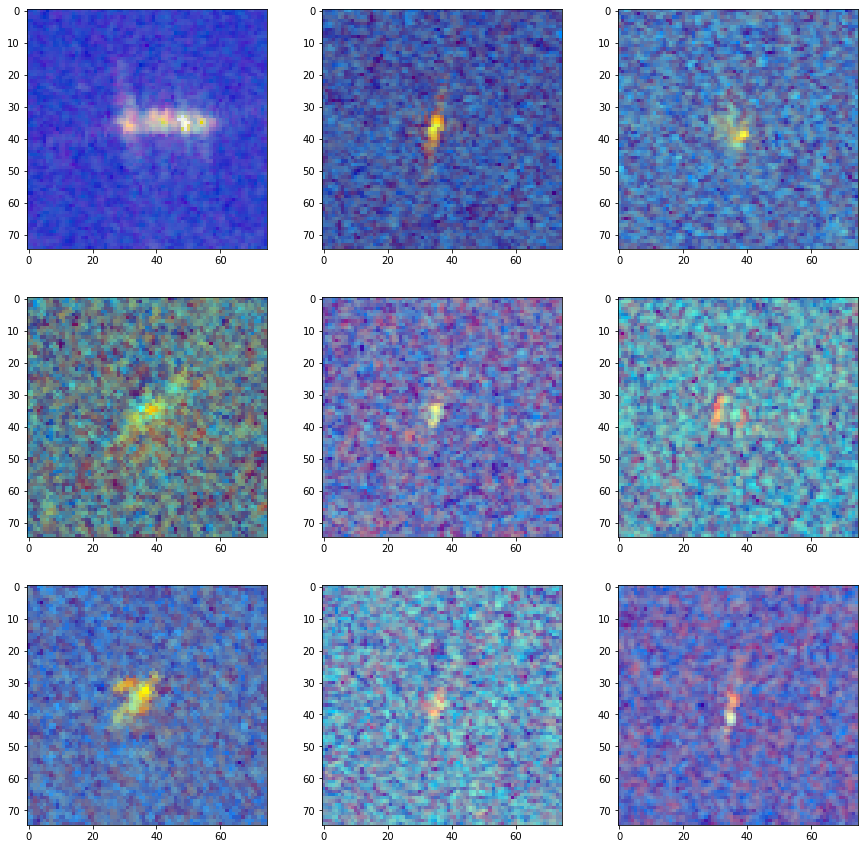

In [26]:
fig = plt.figure(200, figsize=(15,15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(subset[i])
plt.show()

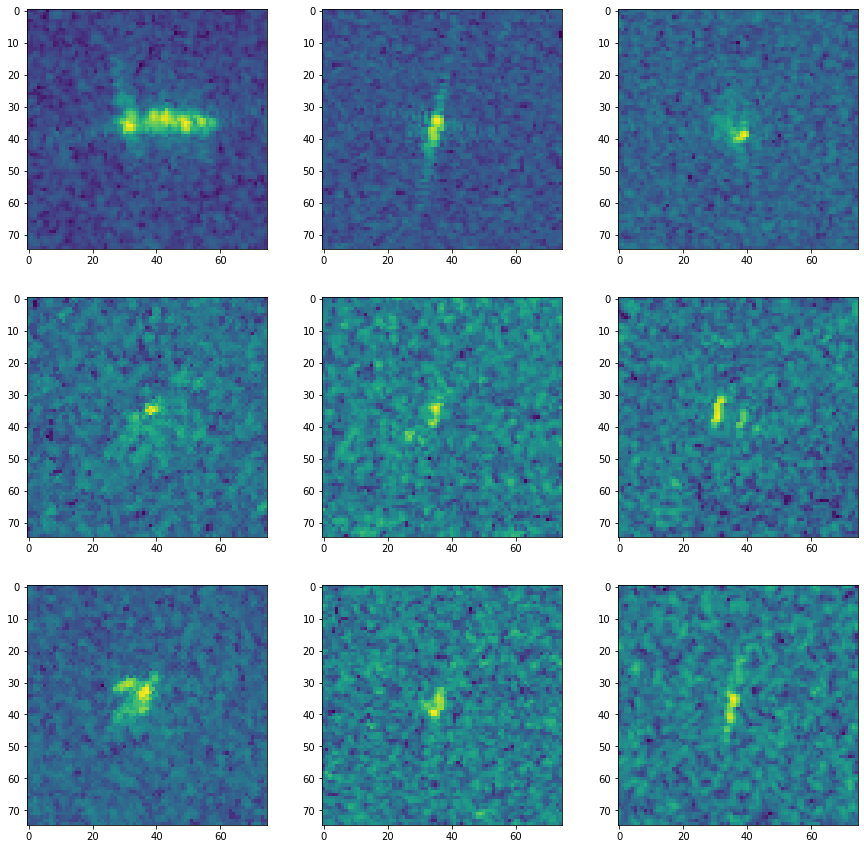

In [27]:
fig = plt.figure(202, figsize=(15,15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75,75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(subset[i])
plt.show()

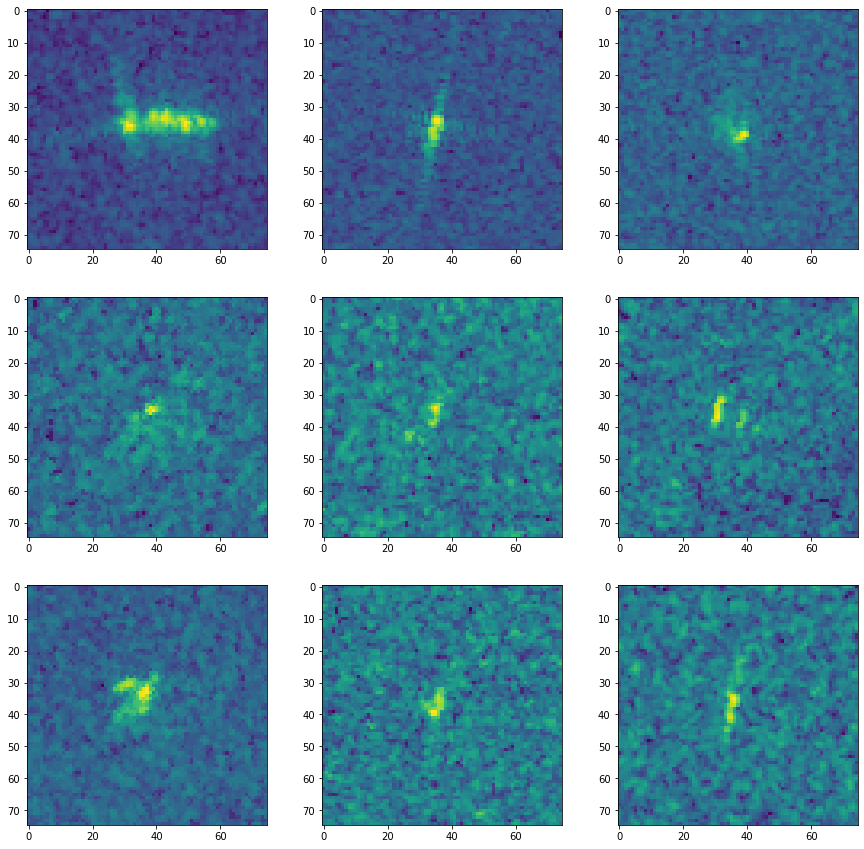

In [28]:
fig = plt.figure(202, figsize=(15,15))
subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75,75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(subset[i])
plt.show()

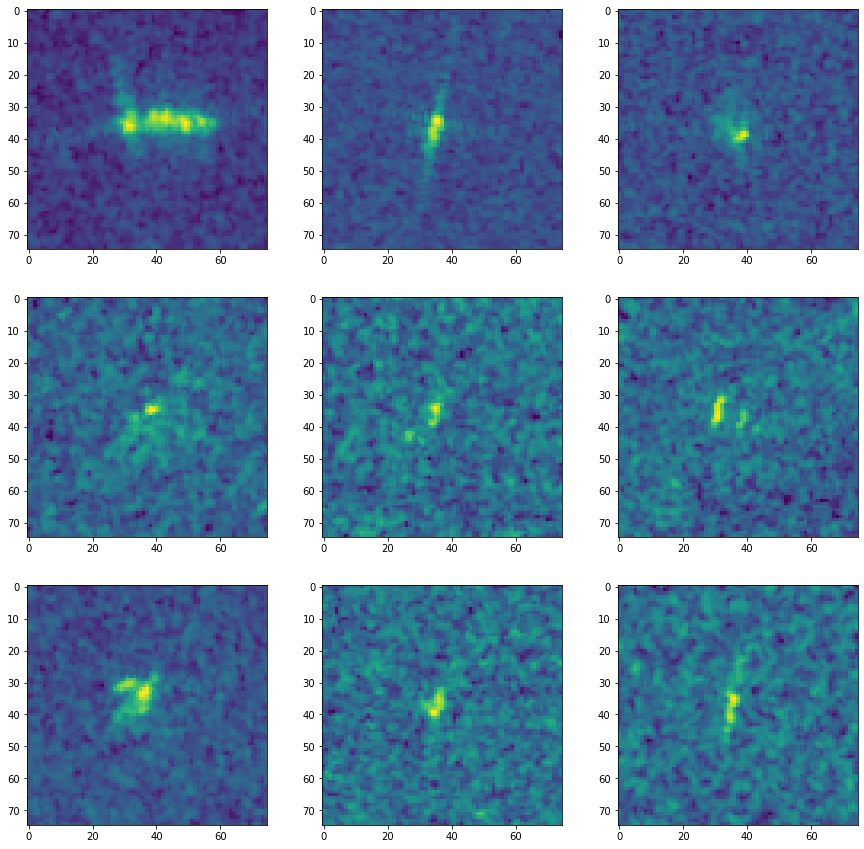

In [30]:
fig = plt.figure(202, figsize=(15,15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75,75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(subset[i])
plt.show()

#### A few words about model

모델 자체는 3개의 컨볼루션 신경망으로 구성된다. 2개의 기본 네트워크와 하나의 네트워크가 결합된다. 서로 다른 데이터 표현에 대해 두 개의 기본 네트워크를 학습시키고, 그 후 공통 네트워크를 학습시키기 위해 학습된 컨볼루션 레이어를 조합하여 사용하는 것이다.

3개의 데이터셋을 사용하는 학습에서, 하나는 네트워크가 한 번만 보고 모델 선택을 위해 keras val split을 디폴트로 한다.

In [33]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle 변수는 angle 파라미터를 사용할지 무시할지를 정의
    input_1 = Input(shape=(75,75,channels))
    
    fcnn = Conv2D(32, kernel_size=(3,3), activation=relu_type)
    fcnn = BatchNormalization()(input_1)
    fcnn = MaxPooling2D((3,3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    
    fcnn = Conv2D(64, kernel_size=(3,3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2,2), strides=(2,2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    
    fcnn = Conv2D(128, kernel_size=(3,3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2,2), strides=(2,2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    
    fcnn = Conv2D(128, kernel_size=(3,3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2,2), strides=(2,2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    
    # angle 데이터를 정규화하지 않는다
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(local_input, output)
    optimizer = Adam(lr=lr, decay=decay)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model, partial_model